In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim

import pandas as pd
import seaborn.apionly as sns
from datetime import date, datetime
from haversine import haversine

# statistics package
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from random import randint
# packages for mapping
from mpl_toolkits.basemap import Basemap

# packages for interactive graphs
from ipywidgets import widgets, interact
from IPython.display import display
from copy import deepcopy as copy
import time
from geopy.geocoders import Nominatim

from time import sleep
import requests
import time,datetime
import os
import json
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
findzip = ZipcodeSearchEngine()

In [4]:
historical_data = pd.read_csv('clean_train_data.csv')

In [5]:
historical_data.head()

,Unnamed: 0,day_interval,distance,dropoff_date,dropoff_datetime,dropoff_hour,dropoff_latitude,dropoff_longitude,dropoff_zipcode,fare_amount,...,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,trip_time_in_secs,vendor_id,waiting_penalty,waiting_time,weather
0,186987.0,2,10.418191,2013-01-13,2013-01-13 20:58:00,20,40.793388,-73.972809,10025,27.0,...,0.5,5.5,4.8,38.3,9.06,1200,VTS,0.000000,0.000000,Rain
1,136205.0,2,0.376856,2013-01-13,2013-01-13 21:10:00,21,40.782097,-73.978867,10024,3.5,...,0.5,0.0,0.0,4.5,0.44,120,VTS,0.029670,21.362104,Rain
2,114412.0,2,0.996570,2013-01-13,2013-01-13 21:35:00,21,40.751007,-73.978104,10168,4.5,...,0.5,0.0,0.0,5.5,0.65,240,VTS,0.691434,497.832494,Rain
3,148407.0,2,4.608048,2013-01-13,2013-01-13 21:46:00,21,40.717236,-74.003563,10278,8.5,...,0.5,1.0,0.0,10.5,2.28,420,VTS,2.600077,1872.055354,Rain
4,114616.0,2,1.231572,2013-01-13,2013-01-13 22:15:00,22,40.739117,-73.987694,10010,4.5,...,0.5,1.0,0.0,6.5,0.91,180,VTS,4.437344,3194.887668,Rain


In [6]:
historical_data.keys()

Index(['Unnamed: 0', 'day_interval', 'distance', 'dropoff_date',
       'dropoff_datetime', 'dropoff_hour', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_zipcode', 'fare_amount', 'hack_license',
       'medallion', 'mta_tax', 'passenger_count', 'payment_type',
       'pickup_date', 'pickup_datetime', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_minute', 'pickup_time',
       'pickup_weekday', 'pickup_zipcode', 'rate_code', 'speed',
       'store_and_fwd_flag', 'surcharge', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'trip_time_in_secs', 'vendor_id',
       'waiting_penalty', 'waiting_time', 'weather'],
      dtype='object')

## Best Revenue from Historical Data

In [7]:
best_revenue = historical_data.groupby(['hack_license','pickup_date'])['total_amount'].sum()

In [8]:
np.max(best_revenue.reset_index()['total_amount'])

1959.2000000000003

## Preprocess

In [9]:
historical_data["dropoff_minute"] = pd.to_datetime(historical_data["dropoff_datetime"]).apply(lambda x: x.minute)
historical_data["dropoff_time"] =historical_data["dropoff_hour"] + (historical_data["dropoff_minute"] / 60)

## Reinforcement Model

In [10]:
class TaxiWorld():
    def __init__(self):
        self.waiting_penalty = 5.00
        pass
                
    def getReward(self, row):
        if row['waiting_time']/3600<=2:
            return row['total_amount'] - row['waiting_time']/3600*self.waiting_penalty
        else:
            return row['total_amount']
        
    
    def set_waiting_penalty(self, penalty):
        self.waiting_penalty = penalty
        
    def getState(self):
        print('Current State')
        return self.s
    
    def setState(self, s):
        self.s = s
        
    def getStateSize(self, trip_and_fare):
        return len(trip_and_fare['zip_code'].unique())
    
    def getZipCodes(self, trip_and_fare):
        return self.zip_codes
    
    def getActionSize(self):
        return len(self.actions)

    def nextAction(self, s):
        print('Calculate Next Action based on state')
        
    def check_Q_table(self, s):
        if s not in self.Q:
            self.Q[s] = dict((action, 0.0) for action in self.actions)
            

In [11]:
env = TaxiWorld()

In [49]:
class TaxiRevenue:
    def __init__(self, env, penalty=5.0, roaming_penalty=10, const=1000, Q_table_file_name='saved_Q.json'):
        self.env = env
        self.penalty=penalty
        self.roaming_penalty = roaming_penalty
        self.const=const
        self.env.set_waiting_penalty(penalty)
        self.Q = dict()
        self.dropPickMap= dict()
        self.Q_table_file_name = Q_table_file_name
        self.load_Q()
        
    def load_Q(self):
        if os.path.isfile(self.Q_table_file_name):
            with open(self.Q_table_file_name, 'r') as fp:
                self.Q = json.load(fp)
    
    def store_Q(self):
        with open(self.Q_table_file_name, 'w') as fp:
            json.dump(self.Q, fp)
        
    def generate_key(self, row):
        return str(row['pickup_zipcode']) + '_'  + str(row['pickup_weekday']) + '_' + str(row['day_interval']) + '_' + str(row['weather'])
    
    def get_tuples(self, key):
        tuples = key.split('_')
        return {'pickup_zipcode': tuples[0],
                   'pickup_weekday': tuples[1],
                   'day_interval': tuples[2],
                   'weather': tuples[3]}
    
    def calculate_penalty(self, pickup_tuple, taxidata):
        if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
            dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
            time= dis/taxidata['speed']
            return time*self.roaming_penalty
        else: 
            return 0
                
        
    def get_meantriptime(self, data):
        map=historical_data.groupby(['pickup_zipcode', 'dropoff_zipcode'])['trip_time_in_secs'].mean()
        return map.reset_index()
    
    def isValidPickup(self, taxidata, dropPickMap):
        key=self.generate_key(taxidata)
        if key in dropPickMap:
            return True
        else:
            return False
        
    def generate_dropPickMap(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            if key not in self.dropPickMap:
                self.dropPickMap[key] = []
            if str([str(row['dropoff_zipcode']), row['total_amount']]) not in self.dropPickMap[key]:
                self.dropPickMap[key].append([str(row['dropoff_zipcode']), row['total_amount']])
        return self.dropPickMap
    
    def getDropoff(self, key, dropPickMap):
        posDropoff= dropPickMap[key]
#         print("dropoffs",posDropoff )
        rand=randint(0, len(posDropoff)-1)
        return posDropoff[rand][0], posDropoff[rand][1]
         
    def getDayInterval(self,hour):
        if hour>=6 and hour<12:
            return 0
        elif hour>=12 and hour<18:
            return 1
        elif hour>=18 and hour<24:
            return 2
        else:
            return 3
        
    def getAction(self, taxidata, _Q,dropPickMap):
        best_reward=0
        #best_key = 0
        s = self.generate_key(taxidata)
        best_key=s
        #print(taxidata)
        if s in _Q:
            best_reward=_Q[s][0]*_Q[s][1]/self.const
        
        zipcode=findzip.by_zipcode(taxidata['dropoff_zipcode'])
        temp=taxidata
        possible_pickup=[]
        returns=10
        radius=5
        while not possible_pickup:
            pickup_res = findzip.by_coordinate(zipcode['Latitude'], zipcode['Longitude'], radius=5, returns=returns)
            for i in range(len(pickup_res)):
                
                temp['pickup_zipcode']=pickup_res[i]['Zipcode']
                dis=self.find_distance(temp['dropoff_zipcode'], temp['pickup_zipcode'])
                time= dis/temp['speed']
                day_interval=self.getDayInterval(temp['dropoff_time']+time)
                temp['day_interval']= day_interval
                #print(temp['pickup_zipcode'])
                if self.isValidPickup(temp, dropPickMap):
                    possible_pickup.append(pickup_res[i]['Zipcode'])

#             print("valid pickup", possible_pickup)
            returns+=10
            radius+=1
        
        for key in _Q:
            tuples=self.get_tuples(key)
               
            
            if tuples['pickup_zipcode'] in possible_pickup and tuples['weather']==str(taxidata['weather']) and tuples['pickup_weekday']==str(taxidata['pickup_weekday']) and tuples['day_interval']==str(taxidata['day_interval']):
            
                tempReward=_Q[key][0]*_Q[key][1]/self.const-self.calculate_penalty(tuples, taxidata)
                
                if tempReward>best_reward:
                    #print("in temp reward: ",tempReward)
                    #print("in best reward: ",best_reward)
                    best_key=key
                    best_reward= tempReward
                    #print(self.get_tuples(best_key))
                    
        return best_key
    
    def build_Q_table(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            reward = self.env.getReward(row)
            if key not in self.Q:
                self.Q[key] = [reward,1]
            else:
                self.Q[key] = [self.Q[key][0] +reward, self.Q[key][1] + 1]
    
    def get_Q_table(self):
        return self.Q
                
    def greedy(self, s):
        return np.argmax(self.Q[s[0]]) 

    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
        
    def train(self, trip_and_fare, Q_table_file_name =  'saved_Q.json'):
        self.Q_table_file_name = Q_table_file_name
        self.build_Q_table(trip_and_fare)
        self.store_Q()
        return self.Q
        
    def distance(self, lat1, lon1, lat2, lon2):
        """calculates the Manhattan distance between 2 points
            using their coordinates

        Parameters
        ----------
        lat1: float
            latitude of first point

        lon1: float
            longitude of first point

        lat2: float
            latitude of second point

        lon2: float
            longitude of second point

        Returns
        -------
        d: float
            The Manhattan distance between the two points in kilometers

        """

        d = haversine((lat1, lon1), (lat2, lon1)) + haversine((lat2, lon1), (lat2, lon2))
        return d
    
    def find_distance(self, zip1, zip2):
        zipcode1=findzip.by_zipcode(zip1)
        zipcode2=findzip.by_zipcode(zip2)
        dis=self.distance(zipcode1['Latitude'], zipcode1['Longitude'],zipcode2['Latitude'], zipcode2['Longitude'])
        return dis
    
    
    def test(self, taxidata, _Q, dropPickMap,meanTrip, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        curr_dropoff_hour=taxidata['dropoff_time']
        #curr_pickup=taxidata['dropoff_time']
        end_time=curr_dropoff_hour+ 12
        
        itinerary = []
        rewards = []
        
        while curr_dropoff_hour <= end_time:
            
            best_key=self.getAction( taxidata, _Q,dropPickMap)
            pickup_tuple= self.get_tuples(best_key)
            
            if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
                dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
                curr_dropoff_hour+= dis/taxidata['speed']
                print("roaming time", str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)) )
                
            dropoff, reward=self.getDropoff(best_key, dropPickMap)
                
            print("going from ",pickup_tuple['pickup_zipcode'], " to ",  dropoff, " at ", time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600)), ' fare cost: ', reward)
            trace = {
                'roaming_time': str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)),
                'start_position': pickup_tuple['pickup_zipcode'],
                'destination': dropoff,
                'current_time': time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600))
            }
            itinerary.append(trace)
            rewards.append(reward)
            #curr_dropoff=curr_dropoff+meanTrip[meanTrip['pickup_zipcode']]
            #print(pickup_tuple['pickup_zipcode'])
            temptrip = meanTrip[(meanTrip['pickup_zipcode']==int(pickup_tuple['pickup_zipcode'])) & (meanTrip['dropoff_zipcode']==int(dropoff))]
            meanTripTime= temptrip.iloc[0]['trip_time_in_secs']
            #print(meanTripTime)
            
            curr_dropoff_hour=curr_dropoff_hour+meanTripTime/3600
            taxidata['dropoff_zipcode']=int(dropoff)
            taxidata['day_interval']=self.getDayInterval(curr_dropoff_hour)
        print('Done')
        return itinerary, rewards

## Train the Model

In [50]:
taxiRevenue = TaxiRevenue(env, 5.0, 10, 1000,  'saved_Q.json')

In [273]:
_Q = taxiRevenue.train(historical_data)

In [43]:
_Q = taxiRevenue.get_Q_table()
len(_Q)

5496

## Generate Test Data

In [20]:
dropPickMap=taxiRevenue.generate_dropPickMap(historical_data)
meanTrip= taxiRevenue.get_meantriptime(historical_data)

In [44]:
meanTrip = pd.read_csv('meanTrip.csv')
with open('dropPickMap.json', 'r') as fp:
        dropPickMap = json.load(fp)

## Test the Model

In [51]:
itinerary, rewards = taxiRevenue.test(historical_data.iloc[333400], _Q, dropPickMap, meanTrip)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


roaming time 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0:05:23.273809
going from  10020  to  10036  at  04:37:23  fare cost:  7.7
roaming time 0:03:34.384876
going from  10119  to  11211  at  04:48:47  fare cost:  16.5
roaming time 0:21:47.253749
going from  10173  to  10022  at  05:32:18  fare cost:  7.0
roaming time 0:03:44.780214
going from  10065  to  10024  at  05:43:13  fare cost:  11.3
roaming time 0:09:50.979939
going from  10021  to  10022  at  06:03:47  fare cost:  9.0
roaming time 0:03:44.780214
going from  10065  to  10028  at  06:14:24  fare cost:  8.5
roaming time 0:06:58.438155
going from  10065  to  10021  at  06:27:04  fare cost:  6.5
roaming time 0:03:06.753693
going from  10065  to  10154  at  06:34:34  fare cost:  9.5
roaming time 0:01:17.809813
going from  10022  to  10020  at  06:42:29  fare cost:  9.5
going from  10020  to  11217  at  06:50:52  fare cost:  30.0
roaming time 0:29:36.290158
going from  10022  to  10020  at  07:46:55  fare cost:  8.9
going from  10020  to  11371  at  07:55:19  fare cost:  41.16
roaming 

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.



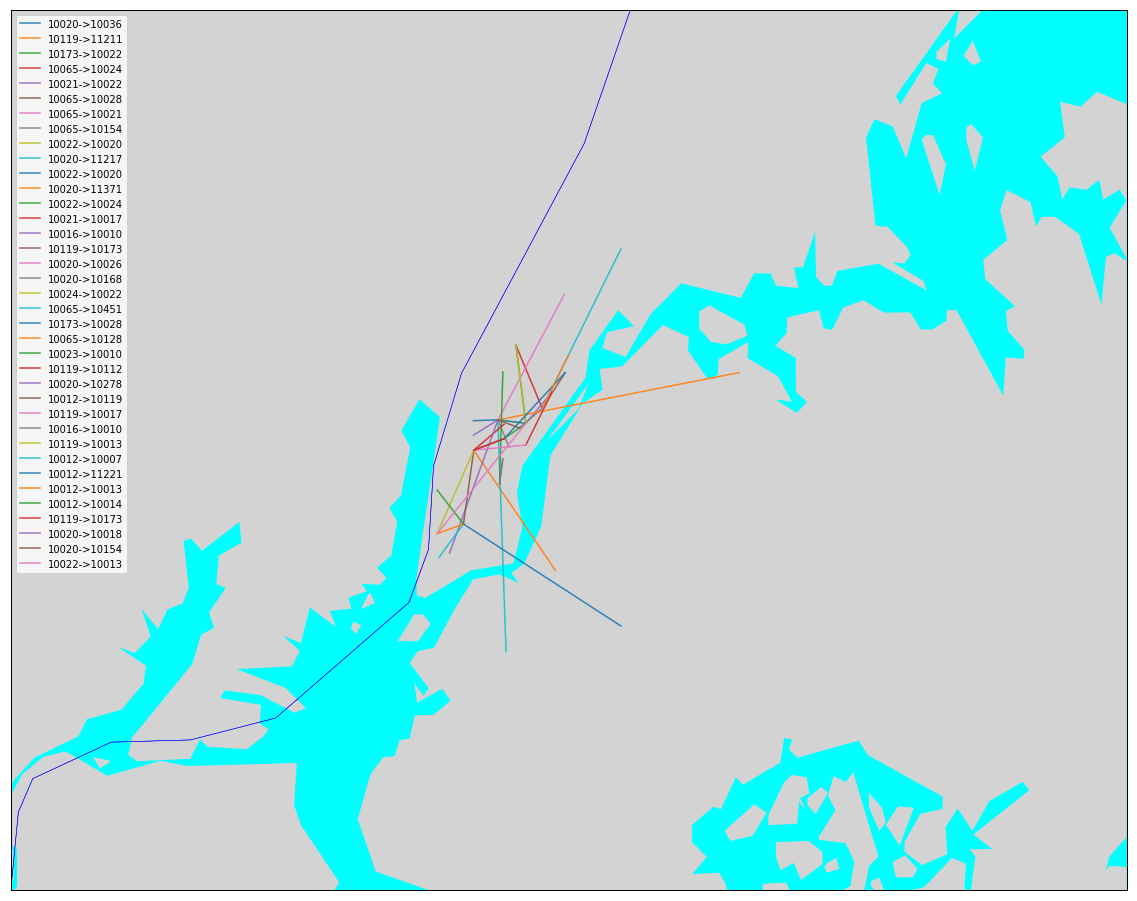

In [52]:
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.6
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

map = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='h', projection='tmerc', lat_0 = cent_lat, lon_0 = cent_lon, area_thresh = 0.1)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='lightgray', lake_color='aqua')
map.drawcountries(linewidth=2)
map.drawstates(color='b')

for trace in itinerary:
    long = []
    lat = []
    start_position = trace['start_position']
    res = findzip.by_zipcode(start_position)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    
    destination = trace['destination']
    res = findzip.by_zipcode(destination)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    x, y = map(long, lat)
    plt.plot(x, y, '-', label=str(start_position)+'->'+str(destination), markersize=10, alpha=0.9)

# plt.show()
plt.legend()

In [58]:
np.sum(rewards)

456.5

In [57]:



from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import numpy as np

init_notebook_mode(connected=True)

long = []
lat = []

for i in range(len(itinerary)):
    src = findzip.by_zipcode(itinerary[i]['start_position'])
    dst = findzip.by_zipcode(itinerary[i]['destination'])
    long.append({'src':src['Longitude'], 'dst': dst['Longitude']})
    lat.append({'src':src['Latitude'], 'dst': dst['Latitude']})

data = []
frames = []
for i in range(len(lat)):
    x = np.linspace(long[i]['src'], long[i]['dst'], 100)
    m = (lat[i]['src'] - lat[i]['dst'])/(long[i]['src']-long[i]['dst'])
    y = m*(x-long[i]['dst']) + lat[i]['dst']

    N=10
    s=np.linspace(long[i]['src'], long[i]['dst'],N)
    xx=s
    yy = m*(xx - long[i]['dst']) + lat[i]['dst']


    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))
    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))


    for k in range(N):
        frames.append(dict(data=[dict(x=[xx[k]], 
                            y=[yy[k]], 
                            mode='markers', 
                            marker=dict(color='red', size=10)
                            )
                      ])) 
lat_min = 40.7
lat_max = 40.8
lon_min = -74.1
lon_max = -73.8
layout=dict(xaxis=dict(range=[lon_min, lon_max], autorange=False, zeroline=False),
            yaxis=dict(range=[lat_min, lat_max], autorange=False, zeroline=False),
            title='Traces for Taxi in a Particular Day', hovermode='closest',
            updatemenus= [{'type': 'buttons',
                           'buttons': [{'label': 'Play',
                                        'method': 'animate',
                                        'args': [None]}]}])

figure1=dict(data=data, layout=layout,  frames=frames)          
iplot(figure1)

## Merge Train Data

In [277]:
train_data1 = pd.read_csv('clean_data.csv')
train_data2 = pd.read_csv('clean_data_2.csv')
train_data3 = pd.read_csv('clean_data_3.csv')
train_data4 = pd.read_csv('clean_data_4.csv')
train_data5 = pd.read_csv('clean_data_5.csv')
frames = [train_data1, train_data2, train_data3, train_data4, train_data5]
result = pd.concat(frames)
result.to_csv('clean_train_data.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [278]:
result.shape

(2905906, 38)

In [37]:
# with open('dropPickMap.json', 'w') as fp:
#         json.dump(dropPickMap, fp)
# meanTrip.to_csv('meanTrip.csv', index=False)

In [38]:
meanTrip = pd.read_csv('meanTrip.csv')
with open('dropPickMap.json', 'r') as fp:
        dropPickMap = json.load(fp)

In [62]:
testcases = []

In [63]:
testcases.append({'itinerary': itinerary, 'rewards': rewards})

In [64]:
with open('testcases.json', 'w') as fp:
        json.dump(testcases, fp)

In [65]:
with open('testcases.json', 'r') as fp:
        testcases = json.load(fp)